<a href="https://colab.research.google.com/github/alessandrotofani/Tesi_magistrale/blob/master/3_Autoencoder_new.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import os
from google.colab import drive
drive.mount('/content/drive')
from sklearn.model_selection import train_test_split

Mounted at /content/drive


In [2]:
import sys 
sys.path.append('/content/drive/MyDrive/Tesi_magistrale/Tesi_magistrale')
import mf

# Preprocessing

## Feature scaling

Implemento il min max scaling delle features. 

Riferimento: https://towardsdatascience.com/data-normalization-with-pandas-and-scikit-learn-7c1cc6ed6475

In [3]:
if not os.path.isfile('/content/drive/MyDrive/Tesi_magistrale/Dataset/IEEE/Output/corr_data.csv'):
  correlation_data = min_max_scaling(correlation_data)
  correlation_data.to_csv(r'./corr_data.csv')

if not os.path.isfile('/content/drive/MyDrive/Tesi_magistrale/Dataset/IEEE/Output/data.csv'):
  correlation_data = pd.read_csv('/content/drive/MyDrive/Tesi_magistrale/Dataset/IEEE/Output/corr_data.csv')

Riferimento `save_model` e `load_model`: https://stackoverflow.com/questions/56107259/how-to-save-a-trained-model-by-scikit-learn

Riferimento confusion matrix: https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html


### Dataset merging

Funzione che ritorna la lista delle colonne significative. 

In [4]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning) # serve per ignorare i FutureWarning

Rimpiazzo i missing values in categorical data con unknown. 

Unisco i dataset numerici e categorici nel dataframe data. 

Riferimento fillna: https://jamesrledoux.com/code/imputation

In [5]:
if not os.path.isfile('/content/drive/MyDrive/Tesi_magistrale/Dataset/IEEE/Output/data.csv'):
  col_to_drop = col_not_sign(categorical_data, cat_sign_col)
  categorical_data = categorical_data.drop(col_to_drop, axis=1)
  categorical_data = categorical_data.fillna('unknown')
  data = pd.merge(correlation_data, categorical_data, left_on='TransactionID', right_on='TransactionID', how='left')
  del correlation_data, categorical_data, numerical_data
  data.to_csv(r'./data.csv')

data = pd.read_csv('/content/drive/MyDrive/Tesi_magistrale/Dataset/IEEE/Output/data.csv')
data.drop(data.columns[data.columns.str.contains('unnamed',case = False)],axis = 1, inplace = True)
data = mf.select_days(data, 60)
data = mf.feature_engineering(data)
data = mf.feature_scaling(data)

## One hot encoding

One hot encoding delle features categoriche. Serve per lo smote e easy ensemble. 

Bisogna farlo prima dello split del dataset poichè rischio di perdere delle colonne. 

In [6]:
data = pd.get_dummies(data)

In [7]:
cols = mf.get_col(data)

Seleziono i dati appartenenti ai primi 60 giorni. 

Se ne seleziono di più, l'easy ensemble non va. 

In [8]:
# data = mf.select_days(data, 60)

## Train validation test split

In [9]:
# data.drop(columns=['TransactionID'], inplace=True)

In [10]:
safe = data[data['isFraud'] == 0]
fraud = data[data['isFraud'] == 1]
# fraud.drop(columns=['isFraud'], inplace=True)
del data

Splitto il dataset in train, validation e test set. 

In [11]:
X_train, X_val, y_train, y_val = mf.split(safe, test_size = 0.2)
del safe
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.25, random_state=42)
del y_train, y_val, y_test

In [12]:
fraud_train, fraud_test, y_fraud_train, y_fraud_test = mf.split(fraud, test_size = 0.2)
del fraud, y_fraud_train, y_fraud_test

In [14]:
train_data = X_train[:10000]

# Autoencoder

### Training

Codice: https://medium.com/swlh/anomaly-detection-with-autoencoders-2bd23dedbd9e

Altro su keras: https://medium.com/datadriveninvestor/deep-autoencoder-using-keras-b77cd3e8be95

In [22]:
from keras.layers import Input, Dense
from keras.models import Model
from tensorflow.keras import metrics

input = Input(shape=(train_data.shape[1],))
encoded = Dense(units=1024, activation='tanh')(input)
encoded = Dense(units=512, activation='relu')(encoded)
encoded = Dense(units=128, activation='relu')(encoded)
##########
decoded = Dense(units=512, activation='tanh')(encoded)
decoded = Dense(units=1024, activation='relu')(decoded)
decoded = Dense(units=train_data.shape[1], activation='relu')(decoded)

In [26]:
autoencoder=Model(input, decoded)
encoder = Model(input, encoded)
autoencoder.summary()
autoencoder.compile(optimizer='adam', loss='mean_squared_error', metrics=[metrics.MeanSquaredError()])

Model: "model_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 882)]             0         
_________________________________________________________________
dense_12 (Dense)             (None, 1024)              904192    
_________________________________________________________________
dense_13 (Dense)             (None, 512)               524800    
_________________________________________________________________
dense_14 (Dense)             (None, 128)               65664     
_________________________________________________________________
dense_15 (Dense)             (None, 512)               66048     
_________________________________________________________________
dense_16 (Dense)             (None, 1024)              525312    
_________________________________________________________________
dense_17 (Dense)             (None, 882)               904

In [ ]:
# history = autoencoder.fit(X_train, X_train, epochs=30, batch_size=10000, shuffle=True,
history = autoencoder.fit(train_data, train_data, epochs=100, batch_size=256, shuffle=True)

# plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
# plt.title('Model Loss')
# plt.ylabel('Loss')
# plt.xlabel('Epoch')
# plt.legend(['Train', 'Test'], loc='upper left')
# plt.show()

In [31]:
from keras.models import Sequential
# autoencoder = load_model(autoencoder_fname)
# autoencoder.layers[0].trainable = False
# autoencoder.layers[1].trainable = False
# autoencoder.layers[2].trainable = False
latent_model = Sequential()
latent_model.add(autoencoder.layers[0])
latent_model.add(autoencoder.layers[1])
latent_model.add(autoencoder.layers[2])
latent_model.add(autoencoder.layers[3])
latent_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 1024)              904192    
_________________________________________________________________
dense_13 (Dense)             (None, 512)               524800    
_________________________________________________________________
dense_14 (Dense)             (None, 128)               65664     
Total params: 1,494,656
Trainable params: 1,494,656
Non-trainable params: 0
_________________________________________________________________


In [ ]:
safe_test = X_test[:1000]
fraud_test = fraud_test[:1000]

In [35]:
X = pd.concat([safe_test, fraud_test], axis = 0).values

In [36]:
y_safe = np.zeros(1000)
y_fraud = np.ones(1000)
y = np.concatenate((y_safe,y_fraud))

In [39]:
from sklearn.manifold import TSNE
def tsne_plot(X, y):
  tsne = TSNE(n_components=2, random_state=0)
  X_t = tsne.fit_transform(X)
  plt.figure(figsize=(12, 8))
  plt.scatter(X_t[np.where(y == 0), 0], X_t[np.where(y == 0), 1], label='Non Fraud', marker='o', color='g')
  plt.scatter(X_t[np.where(y == 1), 0], X_t[np.where(y == 1), 1], label='Fraud', marker='o', color='r')
  plt.legend(loc="best")
  plt.show()

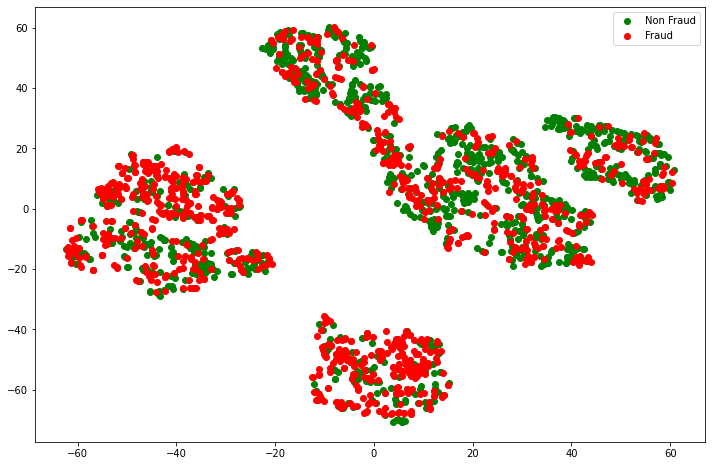

In [40]:
tsne_plot(X,y)

In [41]:
latent_model.compile(optimizer='adam', loss='mean_squared_error', metrics=[metrics.MeanSquaredError()])

In [45]:
X_latent = []
for element in X:
  X_latent.append(latent_model.predict(np.expand_dims(element, axis=0))[0])
X_latent[0].shape

(128,)

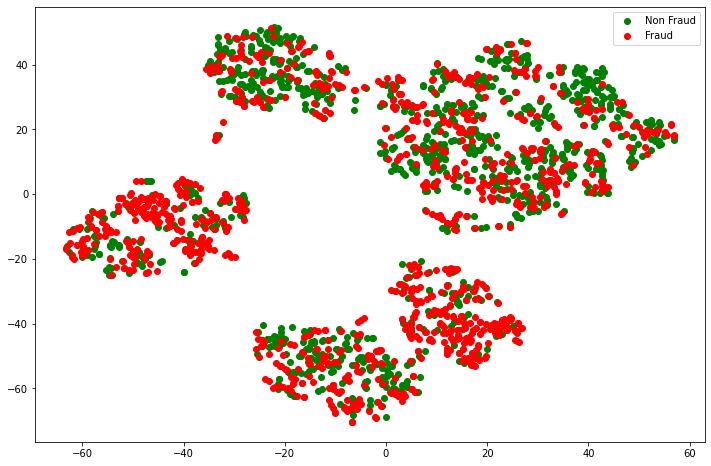

In [46]:
tsne_plot(X_latent,y)

In [47]:
X_train

,TransactionDT,TransactionAmt,card1,card2,card3,card5,addr1,addr2,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D10,D15,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,...,screen_h_3150,screen_h_3240,screen_h_3600,screen_h_450,screen_h_480,screen_h_5000,screen_h_540,screen_h_576,screen_h_600,screen_h_615,screen_h_640,screen_h_648,screen_h_675,screen_h_697,screen_h_712,screen_h_720,screen_h_721,screen_h_750,screen_h_756,screen_h_768,screen_h_774,screen_h_800,screen_h_801,screen_h_803,screen_h_810,screen_h_837,screen_h_840,screen_h_857,screen_h_864,screen_h_889,screen_h_900,screen_h_922,screen_h_924,screen_h_945,screen_h_946,screen_h_947,screen_h_960,screen_h_972,screen_h_990,screen_h_992
134079,0.507657,0.001149,0.930559,0.390342,0.381679,0.589388,0.338675,0.877533,0.000213,0.000527,0.0,0.000000,0.002865,0.000444,0.000000,0.0000,0.004762,0.000000,0.000314,0.000000,0.003084,0.000700,0.287332,0.301386,0.665632,0.517167,0.398642,0.956897,0.694597,0.103407,0.167129,0.051233,0.401198,0.186992,0.114973,0.194361,0.096386,0.140401,0.43662,0.281007,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
131824,0.494994,0.006630,0.586744,0.460992,0.381679,0.589388,0.347872,0.877533,0.000213,0.000176,0.0,0.000000,0.000000,0.000444,0.000000,0.0000,0.004762,0.000000,0.000314,0.000000,0.000000,0.000000,0.027489,0.287333,0.526455,0.517167,0.398642,0.956897,0.694597,0.103407,0.167129,0.051233,0.401198,0.186992,0.114973,0.194361,0.096386,0.140401,0.43662,0.281007,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
102208,0.386023,0.013926,0.586744,0.460992,0.381679,0.589388,0.225865,0.877533,0.000213,0.000176,0.0,0.000000,0.000000,0.000444,0.000000,0.0000,0.004762,0.000000,0.000314,0.000000,0.000343,0.000700,0.027489,0.287333,0.526455,0.517167,0.398642,0.956897,0.694597,0.103407,0.167129,0.051233,0.401198,0.186992,0.114973,0.194361,0.096386,0.140401,0.43662,0.281007,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
17463,0.077140,0.003656,0.456024,0.604059,0.381679,0.589388,0.273687,0.877533,0.000213,0.000351,0.0,0.000000,0.000000,0.000444,0.000000,0.0000,0.004762,0.000000,0.000314,0.000000,0.002742,0.000700,0.746235,0.287333,0.659715,0.517167,0.398642,0.956897,0.694597,0.103407,0.167129,0.051233,0.401198,0.186992,0.114973,0.194361,0.096386,0.140401,0.43662,0.281007,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
10131,0.044958,0.001871,0.672281,0.688839,0.381679,0.589388,0.418991,0.877533,0.000213,0.000351,0.0,0.000000,0.000000,0.000444,0.000000,0.0000,0.004762,0.000000,0.000314,0.000000,0.006511,0.000700,0.762950,0.336290,0.578601,0.517167,0.398642,0.956897,0.694597,0.103407,0.167129,0.051233,0.401198,0.186992,0.114973,0.194361,0.096386,0.140401,0.43662,0.281007,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
214743,0.963473,0.003372,0.543056,0.688839,0.381679,0.589388,0.341741,0.877533,0.000213,0.000351,0.0,0.000000,0.002865,0.000444,0.000000,0.0000,0.009524,0.000000,0.000314,0.000000,0.003427,0.000700,0.527420,0.368475,0.619427,0.517167,0.398642,0.956897,0.694597,0.103407,0.167129,0.051233,0.401198,0.186992,0.114973,0.194361,0.096386,0.140401,0.43662,0.281007,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
99121,0.373844,0.002403,0.543458,0.460233,0.381679,0.474788,0.274300,0.877533,0.000213,0.000176,0.0,0.000000,0.000000,0.000444,0.000000,0.0000,0.004762,0.000000,0.000314,0.000000,0.000343,0.000700,0.027489,0.287333,0.526455,0.517167,0.398642,0.956897,0.694597,0.103407,0.167129,0.051233,0.401198,0.186992

### Scelta della soglia

Calcolo la ricostruzione dei validation set fatta dall'autoencoder. 

Calcolo il MSE per ogni feature vector e costruisco due dataset che poi unirò. 

In [ ]:
mse_df = mf.make_df(X_val, fraud_train, autoencoder)

hline: https://stackoverflow.com/questions/60309406/draw-horizontal-line-on-facetplot-seaborn-relplot

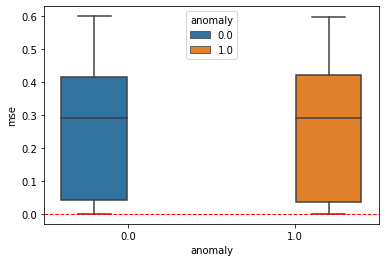

In [ ]:
plot = sns.boxplot(x='anomaly', y='mse', hue='anomaly', data = mse_df)
soglia = 0.0015
plot.axhline(soglia, ls='--', linewidth=1, color='red')

plt.show()

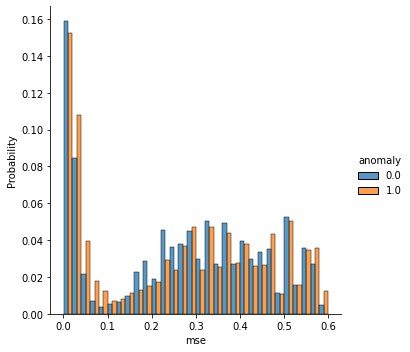

In [ ]:
sns.displot(mse_df, x="mse", hue="anomaly", stat="probability", common_norm=False, multiple = 'dodge')

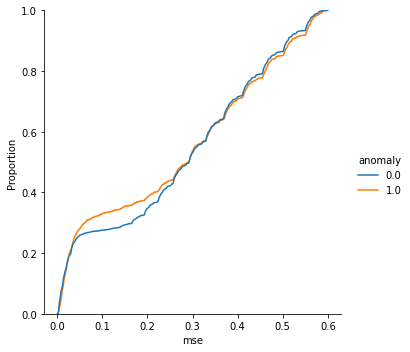

In [ ]:
sns.displot(mse_df, x="mse", hue="anomaly", kind="ecdf")

Pandas quantile: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.quantile.html

In [ ]:
print(mse_df[mse_df['anomaly'] == 0].quantile(0.5)[0].round(5))
print(mse_df[mse_df['anomaly'] == 1].quantile(0.3)[0].round(5))

0.2922
0.06051


In [ ]:
soglia = mse_df[mse_df['anomaly'] == 0].quantile(0.5)[0].round(5)

# Performance measure

Recall:  0.5021209713230654
Average Precision:  0.031242360683226594
F1 score:  0.3611922317947061
[[21575 21212]
 [  687   687]]
AUC:  0.5021209713230654


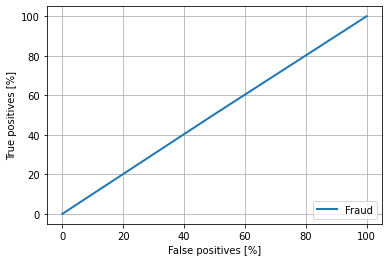

In [ ]:
conf_matrix, recall, precision, f1 = mf.performance_autoencoder(X_test, fraud_test, autoencoder, soglia)